# [Bacterial Colony Growth](@id Bacteries)

In this example, we are going to create a bacterial model and grow a colony using it.

 - The implementation of the force interaction dynamics is the one presented by [Volfson et al. (2008)](https://www.pnas.org/doi/abs/10.1073/pnas.0706805105)
 - We use GPU accelerated dynamics

As described in other models, it is advised that the models are constructed by parts to avoid having to find bugs in a very complex system. Hence, we will split the model in two parts:

 - Forces model
 - Growth model

## Load the packages

In [1]:
import Pkg
Pkg.activate("../")
Pkg.instantiate()


  Activating project at `c:\Users\u256063\Desktop\Projects\ABM_2\ABM_CBM`
Precompiling project...
┌ Warning: attempting to remove probably stale pidfile
│   path = "C:\\Users\\u256063\\.julia\\compiled\\v1.10\\Cairo_jll\\ouRHo_bw8Y1.ji.pidfile"
└ @ FileWatching.Pidfile C:\Users\u256063\AppData\Local\Programs\Julia-1.10.4\share\julia\stdlib\v1.10\FileWatching\src\pidfile.jl:244
  ✓ StructArrays → StructArraysGPUArraysCoreExt
  ✓ Cairo_jll
  ✓ IntervalArithmetic → IntervalArithmeticForwardDiffExt
  ✓ HarfBuzz_jll
  ✓ libass_jll
  ✓ Pango_jll
  ✓ libdecor_jll
  ✓ GLFW_jll
  ✓ FFMPEG_jll
  ✓ GLFW
  ✓ Makie
  ✓ GLMakie
  12 dependencies successfully precompiled in 128 seconds. 425 already precompiled.


In [2]:
import Pkg; Pkg.add(["Revise", "GLMakie"])

   Resolving package versions...
  No Changes to `C:\Users\u256063\Desktop\Projects\ABM_2\ABM_CBM\Project.toml`
  No Changes to `C:\Users\u256063\Desktop\Projects\ABM_2\ABM_CBM\Manifest.toml`
Precompiling project...
  ✓ DiffEqBase → DiffEqBaseDistributionsExt
  ✓ ImageAxes
  ✓ ImageMetadata
  ✓ Netpbm
  ✓ DiffEqNoiseProcess
  ✓ StochasticDiffEq
  ✓ DifferentialEquations
        Info Given CellBasedModels was explicitly requested, output will be shown live 
┌ Warning: CUDA runtime library nvrtc64_112_0.dll was loaded from a system path. This may cause errors.
│ Ensure that you have not set the LD_LIBRARY_PATH environment variable, or that it does not contain paths to CUDA libraries.
└ @ CUDA C:\Users\u256063\.julia\packages\CUDA\jdJ7Z\src\initialization.jl:187
┌ Warning: CUDA runtime library nvrtc64_112_0.dll was loaded from a system path. This may cause errors.
│ Ensure that you have not set the LD_LIBRARY_PATH environment variable, or that it does not contain paths to CUDA libraries.


In [3]:
using Revise
using CellBasedModels
using CUDA
using Distributions
using GLMakie
import GLMakie: Point3f, Cylinder, Sphere, NoShading #Can be changes to Cairo or CLMakie

[ Info: Precompiling CellBasedModels [388cb286-f2b1-4654-a3bb-2e137a39c658]
┌ Warning: CUDA runtime library nvrtc64_112_0.dll was loaded from a system path. This may cause errors.
│ Ensure that you have not set the LD_LIBRARY_PATH environment variable, or that it does not contain paths to CUDA libraries.
└ @ CUDA C:\Users\u256063\.julia\packages\CUDA\jdJ7Z\src\initialization.jl:187
┌ Warning: CUDA runtime library nvrtc64_112_0.dll was loaded from a system path. This may cause errors.
│ Ensure that you have not set the LD_LIBRARY_PATH environment variable, or that it does not contain paths to CUDA libraries.
└ @ CUDA C:\Users\u256063\.julia\packages\CUDA\jdJ7Z\src\initialization.jl:187
┌ Warning: CUDA runtime library nvrtc64_112_0.dll was loaded from a system path. This may cause errors.
│ Ensure that you have not set the LD_LIBRARY_PATH environment variable, or that it does not contain paths to CUDA libraries.
└ @ CUDA C:\Users\u256063\.julia\packages\CUDA\jdJ7Z\src\initialization.jl:1

## Forces model

We already use the defined forces model that is implemented in CBMModels. This is an exact copy of the rod model that you can find already predefined in `Models/rods.jl`. You can check the `Models` section of the documentation for more details.


In [4]:
rod2D = ABM(2,
    agent = Dict(
            :vx=>Float64,
            :vy=>Float64,
            :theta=>Float64,
            :ω=>Float64,
            :d=>Float64,
            :l=>Float64,
            :m=>Float64,
            :fx=>Float64,
            :fy=>Float64,
            :W=>Float64,
            :pressure=>Float64
        ),    #Local Interaction Parameters

    model = Dict(
            :kn=>Float64,
            :γn=>Float64,
            :γt=>Float64,
            :μcc=>Float64,
            :μcw=>Float64,
            :β=>Float64,
            :βω=>Float64
        ),        #Global parameters

    agentODE = quote

        fx = 0
        fy = 0
        W = 0
        pressure = 0
        @loopOverNeighbors i2 begin

            #Use the model provided in the documentation
            Fijx, Fijy, Wij = CBMModels.rodForces(
                                    x,y,d,l,theta,vx,vy,m,
                                    x[i2],y[i2],d[i2],l[i2],theta[i2],vx[i2],vy[i2],m[i2],
                                    kn,γn,γt,μcc,μcw
                                )

            #Append the interaction forces
            fx += Fijx
            fy += Fijy
            #Append radial forces
            W += Wij
            #Keep track of preassure in the media
            pressure += sqrt(Fijx^2+Fijy^2)
            
        end

        #Equations
        dt(x) =  vx 
        dt(y) =  vy 
        dt(vx) =  -β*vx+fx/m 
        dt(vy) =  -β*vy+fy/m 
        dt(theta) =  ω 
        dt(ω) =  W/(m*(d+l)^2/12+m*d^2)-βω*ω 
        
    end,

    neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4),
    platform=GPU(),
    agentAlg = CBMIntegrators.Heun()
);


### Initialize a community with two bacteries and check forces

In [5]:
com = Community(rod2D,
            N=2,
            dt=0.1,
            simBox = [-20 20;-20 20.],
            );

#Natural units scales
m = 1/100
g = 1/10000
d = 1
#Model constants
com.kn = 2E6      * (m*g/d)
com.γn = 2.2E2    * sqrt(g/d)
com.γt = 2.2E2    * sqrt(g/d)
com.μcc = 0.1
com.μcw = 0.8
com.β = .8
com.βω = .8
#Agent parameters
com.m = 1
com.d = 1
com.l = 3;
    # You can play to put different positions and angles here and see the behaviour of the interacting bacteries
com.x = [0.,1]
com.y = [0.,1]
com.theta = [0,π/2];

In [6]:
evolve!(com,steps=50,saveEach=1,preallocateAgents=0)

In [7]:
function plotRods2D!(ax, x, y, d, l, angle; kargs...)

    Main.meshscatter!(ax,
                x.+l./2 .*cos.(angle),
                y.+l./2 .*sin.(angle),
                marker=Sphere(Point3f(0,0,0.),Float32(1)),
                markersize=[
                    Point3f(i/2,i/2,0)
                    for i in d
                ];
                kargs...
            )

    Main.meshscatter!(ax,
                x.-l./2 .*cos.(angle),
                y.-l./2 .*sin.(angle),
                marker=Sphere(Point3f(0,0,0),Float32(1)),
                markersize=[
                    Point3f(i/2,i/2,0)
                    for i in d
                ];
                kargs...
            )
            
    Main.meshscatter!(ax,
                x,
                y,
                marker=Cylinder(Point3f(-.5,0,0),Point3f(.5,0,0),Float32(1)),
                markersize=[Point3f(ll,dd/2,dd/2) for (ll,dd) in zip(l,d)],
                rotation=angle;
                kargs...
            )

    return

end


plotRods2D! (generic function with 1 method)

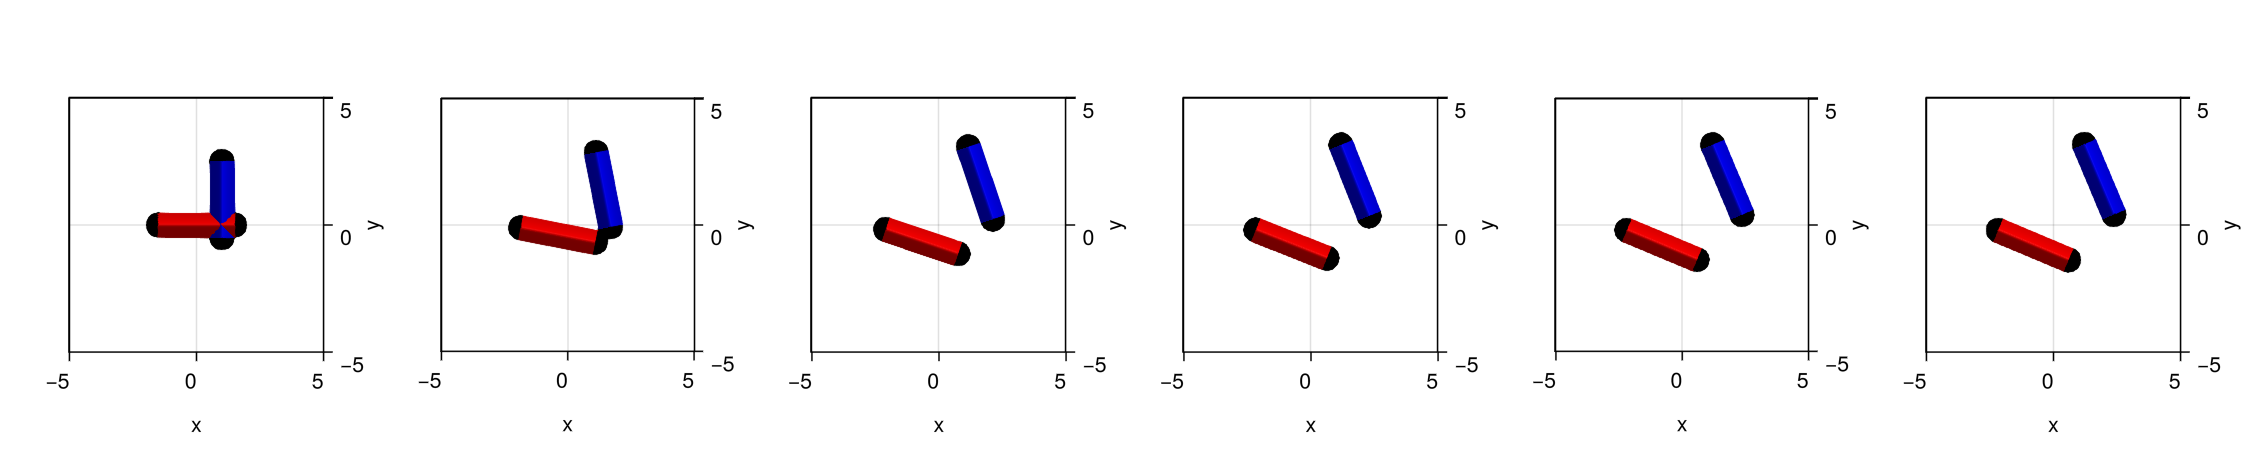

In [8]:
fig = Figure(size=(1500,300))

for (i,j) in enumerate([1:round(Int,length(com)/4):length(com);length(com)])
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )

    plotRods2D!(ax,com[j][:x],com[j][:y],com[j][:d],com[j][:l],com[j][:theta],color=[:red,:blue])
    xlims!(-5,5)
    ylims!(-5,5)
end

fig

## Growth model

We construct over the forces model to add bacterial growth and cell division rules.

In [9]:
rods2dGrowth = ABM(2,
    baseModelInit = [rod2D],

    agent = Dict(
                :lTarget => Float64
            ),

    model = Dict(
                :growth=>Float64,
                :σlTarget=>Float64,
                :lMax=>Float64,
                :α=>Float64
            ),

    agentODE = quote
        dt(l) = growth/(1+α*pressure) #linear growth with growth dependent on the pressure over the cell
    end,

    agentRule = quote #Bound cells
        #Add division
        if l > lTarget
            ww = CBMDistributions.uniform(-.001,.001) #To add some random torque at division time
            #Add a new cell
            @addAgent(
                    x=(l+d)/4*cos(theta)+x,
                    y=(l+d)/4*sin(theta)+y,
                    l=(l-d)/2,
                    ω = ww,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget) #New target length at which the bactery should divide
                    )
            #Add a second cell
            @addAgent(
                    x=-(l+d)/4*cos(theta)+x,
                    y=-(l+d)/4*sin(theta)+y,
                    l=(l-d)/2,
                    ω = -ww,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget) #New target length at which the bactery should divide
                    )
            #Remove the old cell
            @removeAgent()
        end
    end,

    neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4),
    platform=GPU(),
    agentAlg=CBMIntegrators.Heun()
);

## Grow colony from one cell

In [10]:
com = Community(rods2dGrowth,
            N=1,
            dt=0.1,
            simBox = [-300 300;-300 300.],
            );

m = 1/100
g = 1/10000
d = 1
com.kn = 2E6      * (m*g/d)
com.γn = 2.2E2    * sqrt(g/d)
com.γt = 2.2E2    * sqrt(g/d)
com.μcc = 0.1
com.μcw = 0.8
com.β = .8
com.βω = .8
com.growth = 1E-6 * (sqrt(g*d)) *100000
com.lMax = 3.     
com.σlTarget = .2 
com.α = 50

com.m = 1.        
com.d = 1.        
com.l = 2.99      
com.lTarget = 3.  

com.x = 0
com.y = 0
com.theta = 0;

com.growth

1-element Vector{Float64}:
 0.001

In [11]:
x_low = Observable(com.x.+com.l./2 .*cos.(com.theta))
y_low = Observable(com.y.+com.l./2 .*sin.(com.theta))
x_high = Observable(com.x.-com.l./2 .*cos.(com.theta))
y_high = Observable(com.y.-com.l./2 .*sin.(com.theta))
x = Observable(com.x)
y = Observable(com.y)
lSize = Observable([Point3f(i,.5,.5) for i in com.l])
theta = Observable(com.theta)
color = Observable(com.pressure)
title = Observable("N=1")

fig = Figure(size=(1000,1000), backgroundcolor = RGBf(239/255,239/255,239/255))
ax = Axis(fig[1,1], title=title, titlesize=50,
    xticklabelsize=30,
    yticklabelsize=30,
    backgroundcolor = RGBf(239/255,239/255,239/255)
)

meshscatter!(ax,
    x_low,
    y_low,
    marker=Sphere(Point3f(0,0,0.),Float32(1)),
    markersize=0.5;
    color=color,
    colorrange=(0.0,0.1),
    shading=NoShading
)

meshscatter!(ax,
    x_high,
    y_high,
    marker=Sphere(Point3f(0,0,0),Float32(1)),
    markersize=0.5;
    color=color,
    colorrange=(0.0,0.1),
    shading=NoShading
)

meshscatter!(ax,
    x,
    y,
    marker=Cylinder(Point3f(-.5,0,0),Point3f(.5,0,0),Float32(1)),
    markersize=lSize,
    rotation=theta;
    color=color,
    colorrange=(0.0,0.1),
    shading=NoShading
)

xlims!(ax,-10, 10)
ylims!(ax,-10, 10)

# hidedecorations!(ax)
hidespines!(ax)

times = []
sizes = []
GLMakie.record(fig, "bacteries.gif", 0:1700; framerate = 24) do iter

    println("Iter ",iter, " N: ", com.N[1])

    loadToPlatform!(com,preallocateAgents=120000)
    t = @elapsed for i in 1:200
        step!(com)
    end
    bringFromPlatform!(com)

    push!(times, t)
    push!(sizes, com.N[1])

    x_low.val = com.x.+com.l./2 .*cos.(com.theta)
    y_low.val = com.y.+com.l./2 .*sin.(com.theta)
    x_high.val = com.x.-com.l./2 .*cos.(com.theta)
    y_high.val = com.y.-com.l./2 .*sin.(com.theta)
    x.val = com.x
    y.val = com.y
    lSize.val = [Point3f(i,.5,.5) for i in com.l]
    theta.val = com.theta
    color.val = com.pressure    
    title.val = "N=$(com.N[1])"

    notify(x_low)
    notify(y_low)
    notify(x_high)
    notify(y_high)
    notify(x)
    notify(y)
    notify(lSize)
    notify(theta)
    notify(color)
    notify(title)

    xlims!(ax,-6-iter/20, 6+iter/20)
    ylims!(ax,-6-iter/20, 6+iter/20)

end

Iter 0 N: 1
Iter 1 N: 2
Iter 2 N: 2
Iter 3 N: 2
Iter 4 N: 2
Iter 5 N: 2
Iter 6 N: 2
Iter 7 N: 2
Iter 8 N: 2
Iter 9 N: 2
Iter 10 N: 2
Iter 11 N: 2
Iter 12 N: 2
Iter 13 N: 2
Iter 14 N: 2
Iter 15 N: 2
Iter 16 N: 2
Iter 17 N: 2
Iter 18 N: 2
Iter 19 N: 2
Iter 20 N: 2
Iter 21 N: 2
Iter 22 N: 2
Iter 23 N: 2
Iter 24 N: 2
Iter 25 N: 2
Iter 26 N: 2
Iter 27 N: 2
Iter 28 N: 2
Iter 29 N: 2
Iter 30 N: 2
Iter 31 N: 2
Iter 32 N: 2
Iter 33 N: 2
Iter 34 N: 2
Iter 35 N: 2
Iter 36 N: 2
Iter 37 N: 2
Iter 38 N: 2
Iter 39 N: 2
Iter 40 N: 2
Iter 41 N: 2
Iter 42 N: 2
Iter 43 N: 2
Iter 44 N: 2
Iter 45 N: 2
Iter 46 N: 2
Iter 47 N: 2
Iter 48 N: 2
Iter 49 N: 2
Iter 50 N: 2
Iter 51 N: 2
Iter 52 N: 2
Iter 53 N: 2
Iter 54 N: 2
Iter 55 N: 2
Iter 56 N: 2
Iter 57 N: 2
Iter 58 N: 2
Iter 59 N: 2
Iter 60 N: 2
Iter 61 N: 2
Iter 62 N: 2
Iter 63 N: 2
Iter 64 N: 2
Iter 65 N: 2
Iter 66 N: 2
Iter 67 N: 2
Iter 68 N: 2
Iter 69 N: 2
Iter 70 N: 2
Iter 71 N: 2
Iter 72 N: 2
Iter 73 N: 2
Iter 74 N: 2
Iter 75 N: 2
Iter 76 N: 2
Iter 77 N

"bacteries.gif"

In [ ]:
times = []
sizes = []

loadToPlatform!(com,preallocateAgents=120000)
for iter in 1:5000
    println("Iter ",iter, " N: ", com.N[1])
    t = @elapsed for i in 1:200
        step!(com)
    end
    push!(times, t)
    CUDA.@allowscalar push!(sizes, com.N[1])
end
bringFromPlatform!(com)

Iter 1 N: 3982
Iter 2 N: 3990
Iter 3 N: 3997
Iter 4 N: 4006
Iter 5 N: 4016
Iter 6 N: 4028
Iter 7 N: 4037
Iter 8 N: 4043
Iter 9 N: 4053
Iter 10 N: 4055
Iter 11 N: 4064
Iter 12 N: 4078
Iter 13 N: 4084
Iter 14 N: 4093
Iter 15 N: 4101
Iter 16 N: 4109
Iter 17 N: 4120
Iter 18 N: 4129
Iter 19 N: 4135
Iter 20 N: 4137
Iter 21 N: 4149
Iter 22 N: 4161
Iter 23 N: 4174
Iter 24 N: 4182
Iter 25 N: 4189
Iter 26 N: 4200
Iter 27 N: 4210
Iter 28 N: 4225
Iter 29 N: 4236
Iter 30 N: 4242
Iter 31 N: 4248
Iter 32 N: 4259
Iter 33 N: 4268
Iter 34 N: 4278
Iter 35 N: 4286
Iter 36 N: 4294
Iter 37 N: 4305
Iter 38 N: 4321
Iter 39 N: 4327
Iter 40 N: 4336
Iter 41 N: 4343
Iter 42 N: 4351
Iter 43 N: 4356
Iter 44 N: 4367
Iter 45 N: 4378
Iter 46 N: 4385
Iter 47 N: 4400
Iter 48 N: 4412
Iter 49 N: 4421
Iter 50 N: 4428
Iter 51 N: 4436
Iter 52 N: 4444
Iter 53 N: 4455
Iter 54 N: 4466
Iter 55 N: 4476
Iter 56 N: 4489
Iter 57 N: 4503
Iter 58 N: 4512
Iter 59 N: 4520
Iter 60 N: 4532
Iter 61 N: 4547
Iter 62 N: 4555
Iter 63 N: 4564
I

In [ ]:
fig = Figure(size=(1000,500), backgroundcolor = RGBf(239/255,239/255,239/255))
ax = Axis(fig[1,1], titlesize=50,
    xlabel="N", xlabelsize=50,
    ylabel="s/200steps (~15min real time)", ylabelsize=30,
    xticklabelsize=30,
    yticklabelsize=30,
    xtickformat="10^{:.0f}",
    backgroundcolor = RGBf(239/255,239/255,239/255),
    # xscale = Makie.pseudolog10,
)

boxplot!(ax, round.(Int,log10.(sizes)), times, width=1)

save("bacteries_scaling.png", fig)

fig

UndefVarError: UndefVarError: RGBf not defined

In [ ]:
evolve!(com,
        steps=150000,saveEach=1000,
        preallocateAgents=1000,
        saveCurrentState=true,
        progressMessage=(com)->if round(Int,com.t/com.dt)%10000 == 0; println("Step: ",round(Int,com.t/com.dt), " N: ", com.N); end)

UndefVarError: UndefVarError: evolve! not defined

In [ ]:
fig = Figure(resolution=(1500,300))

for (i,j) in enumerate([1:round(Int,length(com)/4):length(com);length(com)])
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )

    CBMPlots.plotRods2D!(ax,com[j][:x],com[j][:y],com[j][:d],com[j][:l],com[j][:theta],
            color=com[j][:pressure], colorrange=(0,0.05))
    xlims!(-20,20)
    ylims!(-20,20)
end

display(fig)

UndefVarError: UndefVarError: Figure not defined